Data needed in input: 
- raw images, split channels (BF, MG, DFHBI) - in "Images" subdirectory of image directory
- segmentation masks for both MG and DFHBI channels via both Otsu and Li automatic thresholding in "Masks_Auto_Otsu" and "Masks_Auto_Li" subdirectories within the image directory, respectively

In [1]:
# Import dependencies
import cv2
import matplotlib as mpl
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from PIL import Image
from skimage.util import img_as_ubyte
from tqdm import tqdm

In [2]:
# Helper function to convert image to 8-bit
def convert_8bit(image): 
    return img_as_ubyte(image)

# Helper function to perform min-max normalisation
def min_max(arr): 
    return (arr - np.min(arr))/(np.max(arr) - np.min(arr))


# Helper function to get preselected ROIs from results file
def get_ROIs_from_results(results, sample, repeat, method): 
    return [results[sample][repeat][method][i]['BoundingBox'] for i in results[sample][repeat][method].keys()]
    

# Pipeline for ROI selection
def pipeline_ROI_selection(
    image_bf, 
    image_ch1, 
    image_ch2, 
    mask_ch1, 
    mask_ch2, 
    check = False, 
    normalise = False, 
    intersect_correct = False, 
    union_correct = False, 
    ROIs_ready = False, 
    ROIs_given = None
): 
    '''
    Takes in brightfield image (`image_bf`), fluorescent channel images (`image_ch1`, `image_ch2`), 
    and corresponding segmentation masks (`mask_ch1`, `mask_ch2`).
    Asks the user to select ROIs in brightfield, then fetches the corresponding patches/ROIs
    in the fluorescent images and segmentation masks. 
    Finally, it computes the ratios between the spurious intensity 
    and the correct one (e.g. ch2 intensity in ch1 mask and viceversa), as well as their average.
    '''
    
    if ROIs_ready == False: 
        # Initialise results dict
        results = {}
        #select ROIs function from cv2
        ROIs = cv2.selectROIs("Select Rois",image_ch1, fromCenter = False)
        cv2.startWindowThread()
        #print rectangle points of selected roi
        print(ROIs)
    elif ROIs_ready == True: 
        # ROIs can be passed in input if already computed and saved
        ROIs = ROIs_given
        results = {}

    # Crop selected roi from image_bf
    # loop over every bounding box save in array "ROIs"
    for ind, rect in enumerate(ROIs):
        x1, y1, x2, y2 = rect

        # crop roi from fluorescent channels and corresponding masks
        ch1_crop = image_ch1[y1:y1+y2,x1:x1+x2]
        mask1_crop = mask_ch1[y1:y1+y2,x1:x1+x2]
        
        ch2_crop = image_ch2[y1:y1+y2,x1:x1+x2]
        mask2_crop = mask_ch2[y1:y1+y2,x1:x1+x2]
        
        
        # Convert to numpy array, then to 8 bit. For masks, invert them.
        ch1_crop = convert_8bit(np.array(ch1_crop))
        ch2_crop = convert_8bit(np.array(ch2_crop))
        mask1_crop = 255-convert_8bit(np.array(mask1_crop))
        mask2_crop = 255-convert_8bit(np.array(mask2_crop))
        
        if intersect_correct == True: 
            # remove intersection between masks
            mask1_crop_corr = mask1_crop - cv2.bitwise_and(mask1_crop, mask2_crop)
            mask2_crop_corr = mask2_crop - cv2.bitwise_and(mask1_crop, mask2_crop)
            # print(np.max(cv2.bitwise_and(mask1_crop, mask2_crop)))
        elif union_correct == True: 
            # turn masks into their union -- completely mixed 
            mask1_crop_corr = cv2.bitwise_or(mask1_crop, mask2_crop)
            mask2_crop_corr = cv2.bitwise_or(mask1_crop, mask2_crop)
        else: 
            mask1_crop_corr = mask1_crop
            mask2_crop_corr = mask2_crop
        
        # normalise Flag allows to perform min max normalisation/standardisation on images
        if normalise == True: 
            ch1_crop = convert_8bit(min_max(ch1_crop))
            ch2_crop = convert_8bit(min_max(ch2_crop))
            
            plt.figure()
            plt.hist(np.array(ch1_crop).reshape(-1, 1))
            plt.hist(np.array(ch2_crop).reshape(-1, 1))
            plt.show()
            
        
        # Calculate average intensity of each channel within own mask
        image1_mask1 = cv2.bitwise_and(ch1_crop, mask1_crop)
        avg1_in1 = np.mean(image1_mask1)
        image2_mask2 = cv2.bitwise_and(ch2_crop, mask2_crop)
        avg2_in2 = np.mean(image2_mask2)
        
        # Calculate average cross-intensity of ch2 within ch1 mask
        image2_mask1 = cv2.bitwise_and(ch2_crop, mask1_crop_corr)
        avg2_in1 = np.mean(image2_mask1)

        # Calculate average cross-intensity of ch1 within ch2 mask
        image1_mask2 = cv2.bitwise_and(ch1_crop, mask2_crop_corr)
        avg1_in2 = np.mean(image1_mask2)
        
        # Plot computed intersection/mixing
        plt.subplots(1, 4, figsize = (12, 3))
        plt.subplot(141)
        plt.imshow(image1_mask1)
        plt.title('Ch1 masked Ch1')
        plt.subplot(142)
        plt.imshow(image2_mask2)
        plt.title('Ch2 masked Ch2')
        plt.subplot(143)
        plt.imshow(image2_mask1)
        plt.title('Cross: Ch2 in Ch1 mask')
        plt.subplot(144)
        plt.imshow(image1_mask2)
        plt.title('Cross: Ch1 in Ch2 mask')
        plt.show()

        # Possible to perform manual checking - but very tedious
        # Rather resorted to checking after the run + remove overlapping ROIs (see below)
        if check == True: 
            decision = input('Check this out: Y to keep, N to discard')
            if decision.upper() == 'N': 
                continue
            
        # produce output dictionary for the specific ROI
        results[ind] = {
            'A_in_A' : avg1_in1,  # MG channel in MG mask
            'A_in_B' : avg1_in2,  # MG channel in DFHBI mask
            'B_in_B' : avg2_in2,  # DFHBI channel in DFHBI mask
            'B_in_A' : avg2_in1,  # DFHBI channel in MG mask
            'A_in_B_ratio' : avg1_in2/avg1_in1,
            'B_in_A_ratio' : avg2_in1/avg2_in2, 
            'AVG_param' : np.mean([avg1_in2/avg1_in1, avg2_in1/avg2_in2]), 
            'BoundingBox' : [x1, y1, x2, y2],  # ROI bounding box
        }
        
    # remove windows
    cv2.destroyAllWindows()
    for i in range (len(ROIs)):
        cv2.waitKey(1)
    
    return results, ROIs
    

In [3]:
# Replace with absolute path to root directory
root_dir = "/ABSOLUTE/PATH/TO/ROOT/DIR/"
# Replace with relative path to image directory within root directory
img_dir = root_dir + "relative_path_to_images/"
# Replace with relative path to results directory within root directory
results_dir = root_dir + "relative_path_to_results/"

In [4]:
# This script assumes img_dir has the following subdirs: /Images, /Masks_Auto_Li, /Masks_Auto_Otsu
os.chdir(img_dir)

# Define filepaths dictionary
sample_keys = ['LTF1/21', 'LTF1/15', 'LTF1/11', 'LTF1/7', 'LTF1/5', 'LTF1/3', 'LTF1/2']
inner_keys = ['BF', 'MG', 'MG_Mask_Li', 'MG_Mask_Otsu', 'DFHBI', 'DFHBI_Mask_Li', 'DFHBI_Mask_Otsu']
files = {key : {inner_key : [] for inner_key in inner_keys} for key in sample_keys}

# Get list of files in all subdirectories of img_dir
file_list = list(
    np.concatenate(
        [
            [path + file for file in os.listdir(path)] 
            for path in ['Images/', 'Masks_Auto_Li/', 'Masks_Auto_Otsu/']
        ]
    )
)

# Define mapping of file patterns to dictionary keys
mapping = {
    'one': 'LTF1/3',
    'two': 'LTF1/2',
    'half': 'LTF1/5',
    'third': 'LTF1/7',
    'fifth': 'LTF1/11',
    'seventh': 'LTF1/15',
    'tenth': 'LTF1/21'
}

# Function to determine mask type
def get_mask_type(file):
    if 'Masks_Auto_Li' in file:
        return '_Mask_Li'
    elif 'Masks_Auto_Otsu' in file:
        return '_Mask_Otsu'
    return ''

# Assign filepaths to correct sample / repetition
for file in file_list:
    for key, sample in mapping.items():
        if key in file:
            if 'BF' in file:
                files[sample]['BF'].append(file)
            elif 'MG' in file and 'mask' not in file:
                files[sample]['MG'].append(file)
            elif ('mask' in file) and ('MG' in file):
                files[sample]['MG' + get_mask_type(file)].append(file)
            elif 'Br' in file and 'mask' not in file:
                files[sample]['DFHBI'].append(file)
            elif ('mask' in file) and ('Br' in file):
                files[sample]['DFHBI' + get_mask_type(file)].append(file)
            break  # Break the inner loop once the correct sample is found
            
# Sort lists to ensure images and masks with 'rep2' appear in matching positions
# for samples (LTF 1/5 and 1/11) which have two replicates
for sample in files.values():
    for key in sample:
        sample[key].sort(key=lambda x: ('rep2' in x, x))

In [ ]:
# Compute intermediate results (with no intersection/union correction)

# Initialise results dictionary
results = {}
# Loop through samples
for sample, prog_ind in zip(files.keys(), tqdm(range(len(files.keys())), desc = 'Sample Progress Bar')):
    results[sample] = {}
    print('Now analysing sample: ', sample)
    num_repeats = len(files[sample]['BF'])
    # and loop through repeats
    for repeat in range(num_repeats):
        results[sample][repeat] = {}
        print('Repeat: ', repeat, '/', num_repeats) 
        # Open images
        image_bf = cv2.imread(files[sample]['BF'][repeat])
        image_mg = cv2.imread(files[sample]['MG'][repeat])
        image_dfhbi = cv2.imread(files[sample]['DFHBI'][repeat])
        counter = 0
        for method in ['Li', 'Otsu']: 
            # Open relevant masks
            mask_mg = cv2.imread(files[sample]['MG_Mask_'+method][repeat])
            mask_dfhbi = cv2.imread(files[sample]['DFHBI_Mask_'+method][repeat])
            
            # Plot images in fluo channels
            plt.subplots(1, 2, figsize = (12, 6))
            plt.subplot(121)
            plt.imshow(image_mg)
            plt.subplot(122)
            plt.imshow(image_dfhbi)
            plt.show()
            
            # Execute pipeline
            # If ROIs have not been selected, execute ROI selection pipeline
            if counter < 1: 
                results[sample][repeat][method], ROIs = pipeline_ROI_selection(
                    image_bf, 
                    image_mg, 
                    image_dfhbi, 
                    mask_mg, 
                    mask_dfhbi,
                )
                counter += 1
            else: 
                # ROIs have been selected for the same sample, different method (Li/Otsu) and can be reused
                print('ROIs are ready! Reapplying the same with method: ', method)
                results[sample][repeat][method], _ = pipeline_ROI_selection(
                    image_bf, 
                    image_mg, 
                    image_dfhbi, 
                    mask_mg, 
                    mask_dfhbi,
                    ROIs_ready=True, 
                    ROIs_given=ROIs
                )
                counter = 0 # reset to select ROIs for next sample

In [ ]:
# Save intermediate results
np.save(results_dir+"intermediate_linker_mixing_results.npy", results, allow_pickle = True)

In [ ]:
# Results can be reloaded if ROI selection pipeline has already been run once up to intermediate results
results = np.load(results_dir+"intermediate_linker_mixing_results.npy", allow_pickle = True).item()

In [ ]:
# Use already calculated bounding boxes (in intermediate results) 
# to recalculate mixing indices, this time normalising image intensity
results_normalised = {}
for sample, prog_ind in zip(files.keys(), tqdm(range(len(files.keys())), desc = 'Sample Progress Bar')):
    if sample in ['LTF1/3', 'LTF1/2']: 
        intersect_correct = False
        union_correct = True
    else: 
        intersect_correct = True
        union_correct = False
    results_normalised[sample] = {}
    print('Now analysing sample: ', sample)
    num_repeats = len(files[sample]['BF'])
    for repeat in range(num_repeats):
        results_normalised[sample][repeat] = {}
        print('Repeat: ', repeat, '/', num_repeats) 
        # Open relevant images
        image_bf = cv2.imread(files[sample]['BF'][repeat])
        image_mg = cv2.imread(files[sample]['MG'][repeat])
        image_dfhbi = cv2.imread(files[sample]['DFHBI'][repeat])

        for method in ['Li', 'Otsu']: 
            # Open relevant masks
            mask_mg = cv2.imread(files[sample]['MG_Mask_'+method][repeat])
            mask_dfhbi = cv2.imread(files[sample]['DFHBI_Mask_'+method][repeat])

            # Execute pipeline with precomputed ROIs
            ROIs = get_ROIs_from_results(results, sample, repeat, method)
            results_normalised[sample][repeat][method], _ = pipeline_ROI_selection(
                image_bf, 
                image_mg, 
                image_dfhbi, 
                mask_mg, 
                mask_dfhbi, 
                check=False, 
                normalise=False, 
                intersect_correct=intersect_correct, 
                union_correct=union_correct, 
                ROIs_ready=True, 
                ROIs_given=ROIs
            )

In [ ]:
# Save final results
np.save(results_dir+"final_linker_mixing_results.npy", results_normalised, allow_pickle = True)

In [5]:
# Results can be reloaded if ROI selection pipeline has already been run once up to intermediate results
results = np.load(results_dir+"final_linker_mixing_results.npy", allow_pickle = True).item()

In [6]:
# Helper function to remove overlapping ROIs which might have been selected by accident
def remove_overlapping_BBoxes(results, min_dist=20):
    for sample, repeats in results.items():
        print(sample)
        for repeat, data in repeats.items():
            # Fetch all bounding boxes for all ROIs of specific repeat
            ROIs_sample = [
                [np.array([x + w / 2, y + h / 2]), w, h]
                for ROI in data['Li'].values()
                for x, y, w, h in [ROI['BoundingBox']]
            ]
            
            # Determine which bounding boxes overlap
            indices_to_remove = set()
            for i, (centre_i, size_x_i, size_y_i) in enumerate(ROIs_sample):
                for j, (centre_j, size_x_j, size_y_j) in enumerate(ROIs_sample[i+1:], start=i+1):
                    if np.linalg.norm(centre_i - centre_j) < min_dist:
                        if size_x_i > size_x_j and size_y_i > size_y_j:
                            indices_to_remove.add(j)
                        else:
                            indices_to_remove.add(i)

            # Remove the overlapping bounding boxes
            for idx in sorted(indices_to_remove, reverse=True):
                ROI_key = list(data['Li'].keys())[idx]
                print('Deleting duplicate ROI:', ROI_key)
                del data['Li'][ROI_key]
                
    return results

In [7]:
# Remove overlapping ROIs to ensure unique droplets
results = remove_overlapping_BBoxes(results, min_dist = 50)

LTF1/21
LTF1/15
LTF1/11
Deleting duplicate ROI: 0
Deleting duplicate ROI: 24
Deleting duplicate ROI: 7
LTF1/7
Deleting duplicate ROI: 28
Deleting duplicate ROI: 27
Deleting duplicate ROI: 15
Deleting duplicate ROI: 11
Deleting duplicate ROI: 6
Deleting duplicate ROI: 3
LTF1/5
Deleting duplicate ROI: 32
LTF1/3
Deleting duplicate ROI: 7
LTF1/2


In [8]:
# Helper function to process and filter results 
def get_dict(results, params, method = 'avg'): 
    out_dict = {}
    for sample in results.keys():
        out_dict[sample] = {}
        for repeat in results[sample].keys():
            for param in params: 
                out_dict[sample][param] = []
                for roi in results[sample][repeat]['Li'].keys(): # does not matter which method, just need to access keys
                    if roi in results[sample][repeat]['Otsu'].keys(): 
                        # Filter ROIs: 
                        # 1. ensure mixing is not NaN (either in A_in_B or B_in_A) in either mask
                        if (
                            (not np.isnan(results[sample][repeat]['Li'][roi]['A_in_B'])) 
                            and (not np.isnan(results[sample][repeat]['Li'][roi]['B_in_A'])) 
                            and (not np.isnan(results[sample][repeat]['Otsu'][roi]['A_in_B'])) 
                            and (not np.isnan(results[sample][repeat]['Otsu'][roi]['B_in_A']))
                        ):
                            # 2. ensure self-intersection is not 0 (i.e. A_in_A, B_in_B) in either mask 
                            # (remove segmentation issues)
                            if (
                                (results[sample][repeat]['Li'][roi]['A_in_A'] != 0) 
                                and (results[sample][repeat]['Li'][roi]['B_in_B'] != 0) 
                                and (results[sample][repeat]['Otsu'][roi]['A_in_A'] != 0) 
                                and (results[sample][repeat]['Otsu'][roi]['B_in_B'] != 0)
                            ):
                                # 3. ensure reasonable values: intersections should not be negative (bottom 4 conditions) 
                                # and all cross-mixing ratios should be between 0 and 1 - this is relaxed to [0-3] to keep some margin.
                                if (
                                    (np.abs(results[sample][repeat]['Li'][roi]['B_in_A_ratio']) <= 3.0) 
                                    and (np.abs(results[sample][repeat]['Otsu'][roi]['B_in_A_ratio']) <= 3.0) 
                                    and (np.abs(results[sample][repeat]['Li'][roi]['A_in_B_ratio']) <= 3.0) 
                                    and (np.abs(results[sample][repeat]['Otsu'][roi]['A_in_B_ratio']) <= 3.0) 
                                    and (np.abs(results[sample][repeat]['Li'][roi]['AVG_param']) <= 3.0) 
                                    and (np.abs(results[sample][repeat]['Otsu'][roi]['AVG_param']) <= 3.0) 
                                    and (np.abs(results[sample][repeat]['Li'][roi]['A_in_B']) >= 0.0) 
                                    and (np.abs(results[sample][repeat]['Li'][roi]['B_in_A']) >= 0.0) 
                                    and (np.abs(results[sample][repeat]['Otsu'][roi]['A_in_B']) >= 0.0) 
                                    and (np.abs(results[sample][repeat]['Otsu'][roi]['B_in_A']) >= 0.0)
                                ): 
                                    if method == 'Li': 
                                        out_dict[sample][param].append(results[sample][repeat]['Li'][roi][param])
                                    elif method == 'Otsu': 
                                        out_dict[sample][param].append(results[sample][repeat]['Otsu'][roi][param])
                                    elif method == 'avg': 
                                        mean_param = (results[sample][repeat]['Li'][roi][param] + results[sample][repeat]['Otsu'][roi][param])/2
                                        out_dict[sample][param].append(mean_param)
    return out_dict

In [9]:
params_avg = get_dict(results, ['A_in_B_ratio', 'B_in_A_ratio', 'AVG_param'], method = 'avg')

# Helper function to count droplets that satisfy filtering requirements per template ratio/sample
def get_num_samples(param_dict):
    numbers = {
        sample: len(next(iter(param_dict[sample].values()))) 
        for sample in param_dict
    }
    for sample, count in numbers.items():
        print(f"Sample {sample}: {count} ROIs")
    return numbers

# Print out number of unique ROIs that 
numbers = get_num_samples(params_avg)

Sample LTF1/21: 30 ROIs
Sample LTF1/15: 34 ROIs
Sample LTF1/11: 30 ROIs
Sample LTF1/7: 37 ROIs
Sample LTF1/5: 37 ROIs
Sample LTF1/3: 43 ROIs
Sample LTF1/2: 44 ROIs


In [10]:
# Setup to convert params_avg into a pandas DataFrame
avg_indices_list = []
a_in_b_indices_list = []
b_in_a_indices_list = []
ratio_list = []

for sample in params_avg.keys(): 
    a_in_b_indices_list += params_avg[sample]['A_in_B_ratio']
    b_in_a_indices_list += params_avg[sample]['B_in_A_ratio']
    avg_indices_list += params_avg[sample]['AVG_param']
    ratio_list += len(params_avg[sample]['AVG_param'])*[sample]

assert len(a_in_b_indices_list) == len(ratio_list)
assert len(b_in_a_indices_list) == len(ratio_list)
assert len(avg_indices_list) == len(ratio_list)

In [11]:
# Produce pandas DataFrame
mixing_avg = pd.DataFrame({'Sample_Template_Ratio': np.array(ratio_list), 
                           'A_in_B_ratio': np.array(a_in_b_indices_list), 
                           'B_in_A_ratio': np.array(b_in_a_indices_list),
                           'AVG_param': np.array(avg_indices_list)})
mixing_avg.replace([np.inf, -np.inf], np.nan, inplace=True)
mixing_avg.dropna(inplace = True)

In [12]:
# Helper function to compute [1st quartile - 1.5*IQR, 3rd quartile + 1.5*IQR] ranges 
# for all sample template ratios, where IQR is the interquartile range.
def get_iqr_ranges(mixing_df, column): 
    """
    Calculate Interquartile Range (IQR)-based lower and upper bounds for a specified column
    in a DataFrame (either 'A_in_B_ratio' or 'B_in_A_ratio'), grouped by the 'Sample_Template_Ratio' column.

    Parameters:
    mixing_df (pd.DataFrame): DataFrame containing the data.
    column (str): The column name for which to calculate the IQR bounds.

    Returns:
    dict: A dictionary where the keys are the unique values from the 'Sample_Template_Ratio' column,
          and the values are lists containing the lower and upper bounds for the IQR-based range.
    """
    
    sample_template_ratios = mixing_df['Sample_Template_Ratio'].unique()
    quantiles = [
        mixing_df[mixing_df['Sample_Template_Ratio'] == i][column].quantile([0.25,0.5,0.75]) 
        for i in sample_template_ratios
    ]
    lower = [
        quantiles[i][0.25] - 1.5*(quantiles[i][0.75] - quantiles[i][0.25]) 
        for i in range(len(sample_template_ratios))
    ]
    upper = [
        quantiles[i][0.75] + 1.5*(quantiles[i][0.75] - quantiles[i][0.25]) 
        for i in range(len(sample_template_ratios))
    ]
    
    lower_upper_ranges = [[i, j] for i,j in zip(lower, upper)]
    
    return dict(
        zip(sample_template_ratios, lower_upper_ranges)
    )

ranges_a_in_b = get_iqr_ranges(mixing_avg, 'A_in_B_ratio')
ranges_b_in_a = get_iqr_ranges(mixing_avg, 'B_in_A_ratio') 

In [13]:
# Helper function to filter out values outside of [1st quartile - 1.5*IQR, 3rd quartile + 1.5*IQR]
def iqr_filter_and_concat_all_ratios(mixing_df, ranges_a_in_b, ranges_b_in_a):
    sample_template_ratios = mixing_df['Sample_Template_Ratio'].unique()
    filtered_dfs = []
    for ratio in sample_template_ratios:
        filtered_df = mixing_df[
            (mixing_df['Sample_Template_Ratio'] == ratio) &
            (mixing_df['A_in_B_ratio'] >= ranges_a_in_b[ratio][0]) &
            (mixing_df['A_in_B_ratio'] <= ranges_a_in_b[ratio][1]) &
            (mixing_df['B_in_A_ratio'] >= ranges_b_in_a[ratio][0]) &
            (mixing_df['B_in_A_ratio'] <= ranges_b_in_a[ratio][1])
        ]
        filtered_dfs.append(filtered_df)
    return pd.concat(filtered_dfs, ignore_index=True)

# Perform filtering
mixing_avg_union = iqr_filter_and_concat_all_ratios(mixing_avg, ranges_a_in_b, ranges_b_in_a)

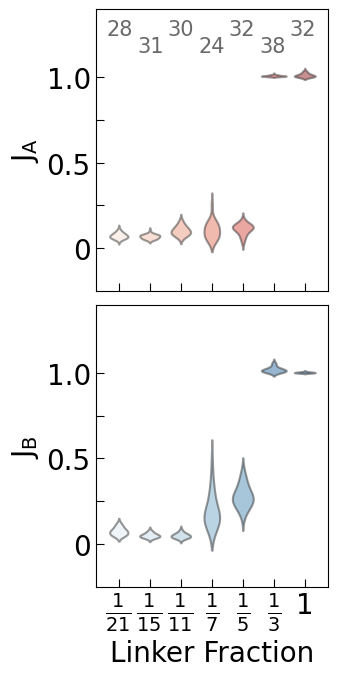

In [14]:
# Plot - Figure 4c
mpl.rcParams['mathtext.default'] = 'regular'

conditions = mixing_avg_union['Sample_Template_Ratio'].unique()
num_droplets = [len(mixing_avg_union[mixing_avg_union['Sample_Template_Ratio'] == i]) for i in conditions]
positions = np.arange(-0.4, 6.5, 6.9/len(num_droplets))

plt.subplots(2, 1, figsize = (3, 7.5), sharex = True, sharey = True)
plt.subplots_adjust(hspace = .05)

plt.subplot(211)
ax = sns.violinplot(
    x = 'Sample_Template_Ratio', 
    y = 'A_in_B_ratio', 
    data = mixing_avg_union, 
    scale = 'count', 
    palette="Reds", 
    inner = None, 
    bw = .7
)
ax.set_xlabel('')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels([], fontsize = 20)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.00])
ax.set_yticklabels([0, '', 0.5, '', 1.00], fontsize = 20)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.00])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.00])
ax.set_ylabel('', fontsize = 20)
ax.tick_params(direction = 'in', length = 6)
ax.set_ylabel(r'$J_{A}$', fontsize = 20)
plt.xlim([-0.75, 6.75])
plt.setp(ax.collections, alpha=.5);

# Plot number of examined droplets up top
plt.text(positions[0], 1.25, num_droplets[0], fontsize = 15, color = 'dimgrey')
plt.text(positions[1], 1.15, num_droplets[1], fontsize = 15, color =  'dimgrey')
plt.text(positions[2], 1.25, num_droplets[2], fontsize = 15, color =  'dimgrey')
plt.text(positions[3], 1.15, num_droplets[3], fontsize = 15, color =  'dimgrey')
plt.text(positions[4], 1.25, num_droplets[4], fontsize = 15, color =  'dimgrey')
plt.text(positions[5], 1.15, num_droplets[5], fontsize = 15, color =  'dimgrey')
plt.text(positions[6], 1.25, num_droplets[6], fontsize = 15, color =  'dimgrey')

plt.subplot(212)
ax2 = sns.violinplot(
    x = 'Sample_Template_Ratio', 
    y = 'B_in_A_ratio', 
    data = mixing_avg_union, 
    scale = 'count', 
    palette="Blues", 
    inner = None, bw = .7
)
ax2.set_xlabel('Linker Fraction', fontsize = 20)
ax2.set_xticks([0, 1, 2, 3, 4, 5, 6])
# Write out xticklabels using LaTeX
ax2.set_xticklabels(
    [r'$\frac{1}{21}$', 
     r'$\frac{1}{15}$', 
     r'$\frac{1}{11}$', 
     r'$\frac{1}{7}$', 
     r'$\frac{1}{5}$', 
     r'$\frac{1}{3}$', 1], 
    fontsize = 20)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1.00])
ax2.set_yticklabels([0, '', 0.5, '', 1.00], fontsize = 20)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1.00])
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1.00])
ax2.set_ylabel(r'$J_{B}$', fontsize = 20)
ax2.tick_params(direction = 'in', length = 6)
plt.xlim([-0.75, 6.75])
plt.ylim([-0.25, 1.40])
plt.setp(ax2.collections, alpha=.5);
plt.show()